In [2]:
# Re-extract data with ALL orderbook levels (all 20 levels)
import sys
import os
import pandas as pd
import json

# Add parent directory to path for imports
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from hyperliquid_snapshots.decompress import decompress_lz4_file

hours = [18]
all_rows = []

for hour in hours:
    lz4_path = os.path.join('..', 'data', 'market_data', '20250610', str(hour), 'l2Book', 'HYPE.lz4')
    json_path = lz4_path.replace('.lz4', '')
    
    # Decompress if not already decompressed
    if not os.path.exists(json_path):
        decompress_lz4_file(lz4_path, remove_src=False)
    
    # Parse JSONL
    with open(json_path, 'r') as f:
        for line in f:
            if line.strip():
                record = json.loads(line)
                raw_data = record.get('raw', {}).get('data', {})
                time = raw_data.get('time', None)
                coin = raw_data.get('coin', None)
                levels = raw_data.get('levels', [])
                
                if len(levels) >= 2:
                    bids = levels[0]
                    asks = levels[1]
                    
                    # Get best bid and ask (for mid price and spread)
                    best_bid_px = float(bids[0]['px']) if bids else None
                    best_bid_sz = float(bids[0]['sz']) if bids else None
                    best_ask_px = float(asks[0]['px']) if asks else None
                    best_ask_sz = float(asks[0]['sz']) if asks else None
                    
                    # Calculate mid price and spread
                    mid_price = (best_bid_px + best_ask_px) / 2 if best_bid_px and best_ask_px else None
                    spread = best_ask_px - best_bid_px if best_bid_px and best_ask_px else None
                    
                    # Sum ALL bid and ask sizes across all levels
                    total_bid_size = sum(float(bid['sz']) for bid in bids)
                    total_ask_size = sum(float(ask['sz']) for ask in asks)
                    
                    all_rows.append({
                        'time': time,
                        'coin': coin,
                        'hour': hour,
                        'best_bid_px': best_bid_px,
                        'best_bid_sz': best_bid_sz,
                        'best_ask_px': best_ask_px,
                        'best_ask_sz': best_ask_sz,
                        'mid_price': mid_price,
                        'spread': spread,
                        'total_bid_size': total_bid_size,
                        'total_ask_size': total_ask_size
                    })

# Create DataFrame
df = pd.DataFrame(all_rows)
df['time'] = pd.to_datetime(df['time'], unit='ms', utc=True)
df = df.sort_values('time').reset_index(drop=True)

print(f"✓ Re-extracted {len(df)} rows with ALL orderbook levels")
print(f"\nNew columns added:")
print(f"  - total_bid_size: Sum of all bid sizes across all 20 levels")
print(f"  - total_ask_size: Sum of all ask sizes across all 20 levels")
print(f"\nTotal size statistics:")
print(df[['total_bid_size', 'total_ask_size']].describe())
df.head(10)

✓ Re-extracted 6599 rows with ALL orderbook levels

New columns added:
  - total_bid_size: Sum of all bid sizes across all 20 levels
  - total_ask_size: Sum of all ask sizes across all 20 levels

Total size statistics:
       total_bid_size  total_ask_size
count     6599.000000     6599.000000
mean      1749.815972     2453.180636
std       1061.626022     3264.777409
min         35.280000       27.080000
25%       1129.950000     1083.640000
50%       1527.050000     1622.410000
75%       2052.305000     2372.635000
max       9165.470000    27654.140000


,time,coin,hour,best_bid_px,best_bid_sz,best_ask_px,best_ask_sz,mid_price,spread,total_bid_size,total_ask_size
0,2025-06-10 17:59:59.890000+00:00,HYPE,18,40.011,88.19,40.012,19.98,40.0115,0.001,7001.77,27443.92
1,2025-06-10 18:00:00.606000+00:00,HYPE,18,40.011,370.74,40.012,19.98,40.0115,0.001,7312.83,27527.41
2,2025-06-10 18:00:01.594000+00:00,HYPE,18,40.011,370.42,40.012,19.98,40.0115,0.001,7626.24,27654.14
3,2025-06-10 18:00:02.051000+00:00,HYPE,18,40.011,369.26,40.012,19.98,40.0115,0.001,7625.08,27506.99
4,2025-06-10 18:00:02.746000+00:00,HYPE,18,40.011,192.38,40.012,30.70,40.0115,0.001,7159.38,27173.26
5,2025-06-10 18:00:02.938000+00:00,HYPE,18,40.011,192.38,40.012,30.70,40.0115,0.001,7201.34,27185.25
6,2025-06-10 18:00:03.086000+00:00,HYPE,18,40.011,178.14,40.012,21.68,40.0115,0.001,6857.89,27412.73
7,2025-06-10 18:00:03.616000+00:00,HYPE,18,40.010,12.02,40.011,150.00,40.0105,0.001,6613.07,1224.98
8,2025-06-10 18:00:04.127000+00:00,HYPE,18,40.001,7.50,40.002,25.00,40.0015,0.001,6466.62,1160.01
9,2025-06-10 18:00:04.679000+00:00,HYPE,18,40.000,5357.48,40.001,12.11,40.0005,0.001,6141.59,1265.90


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime

# Load the pool events data
df_events = pd.read_csv(os.path.join('..', 'data', 'pool_data', 'pool_events.csv'))

print(f"Loaded {len(df_events)} swap events")
print(f"\nColumns: {list(df_events.columns)}")
print(f"\nFirst few rows:")
df_events.head()


Loaded 87 swap events

Columns: ['event', 'tx_hash', 'block', 'timestamp', 'log_index', 'token_0_balance_before', 'token_0_balance_after', 'token_1_balance_before', 'token_1_balance_after', 'sender', 'recipient', 'amount0', 'amount1', 'sqrtPriceX96', 'liquidity', 'tick']

First few rows:


,event,tx_hash,block,timestamp,log_index,token_0_balance_before,token_0_balance_after,token_1_balance_before,token_1_balance_after,sender,recipient,amount0,amount1,sqrtPriceX96,liquidity,tick
0,Swap,1271a12f62208f1ab6dfd7ca66fd0083a85653c48507a6...,5421764,1749578528,11,40652.888209,40630.200102,583403.330221,584082.080221,0x1dA6b648B829ACBE15eb747c3468e1C55d7B92C0,0x1dA6b648B829ACBE15eb747c3468e1C55d7B92C0,62679804037233235,-2505875,500684859609271882943304,253293152038817,-239450
1,Swap,809add547ac8eccc54cc16fbffc9bced7d3c2047181162...,5421765,1749578529,8,40571.888122,40547.908304,585702.710206,586581.710206,0xCCC5C030689364f80eA993565B8C4109E978809A,0xCCC5C030689364f80eA993565B8C4109E978809A,-41589266438818455,1663486,501204925075932443418061,253293152038817,-239429
2,Swap,43efb397e4c7991710ccef7057ba940f31c803ce7c67cd...,5421971,1749578732,3,40423.704773,40423.704773,591138.953391,591138.953391,0x4E2960a8cd19B467b82d26D83fAcb0fAE26b094D,0xB8B98f25147F3c3688312944f924DB0bfB68412F,10000000000000000,-399894,501079840999259953238323,253293152038817,-239434
3,Swap,3e456c90d7db59635c35169cfca795eb56b1a1392cbb34...,5422027,1749578787,4,40423.704773,40423.704773,591138.953391,591138.953391,0x4E2960a8cd19B467b82d26D83fAcb0fAE26b094D,0x4E2960a8cd19B467b82d26D83fAcb0fAE26b094D,-9989979337785596,399894,501204862228349965988057,253293152038817,-239429
4,Swap,1d45da48d9c2745a96c14c3a9b4accebd1e90ea4262913...,5422168,1749578926,10,40355.739593,40355.739593,593636.382099,593636.382099,0x1dA6b648B829ACBE15eb747c3468e1C55d7B92C0,0x1dA6b648B829ACBE15eb747c3468e1C55d7B92C0,-100189294583147514,4021592,502462156451047485937298,253293152038817,-239379


In [4]:
# Load gas data
df_gas = pd.read_csv('../data/pool_data/tx_costs.csv')

# Merge gas data into df_events on tx_hash
df_events = df_events.merge(
    df_gas[['tx_hash', 'gasPaidWei']],
    on='tx_hash',
    how='left'
)

# Convert gasPaidWei to HYPE (assuming 18 decimals for HYPE)
df_events['gas_paid_hype'] = df_events['gasPaidWei'] / 1e18

# Now you can use 'gas_paid_hype' in your effective price calculation as before

In [5]:
df_events

,event,tx_hash,block,timestamp,log_index,token_0_balance_before,token_0_balance_after,token_1_balance_before,token_1_balance_after,sender,recipient,amount0,amount1,sqrtPriceX96,liquidity,tick,gasPaidWei,gas_paid_hype
0,Swap,1271a12f62208f1ab6dfd7ca66fd0083a85653c48507a6...,5421764,1749578528,11,40652.888209,40630.200102,583403.330221,584082.080221,0x1dA6b648B829ACBE15eb747c3468e1C55d7B92C0,0x1dA6b648B829ACBE15eb747c3468e1C55d7B92C0,62679804037233235,-2505875,500684859609271882943304,253293152038817,-239450,105770000000000,0.000106
1,Swap,809add547ac8eccc54cc16fbffc9bced7d3c2047181162...,5421765,1749578529,8,40571.888122,40547.908304,585702.710206,586581.710206,0xCCC5C030689364f80eA993565B8C4109E978809A,0xCCC5C030689364f80eA993565B8C4109E978809A,-41589266438818455,1663486,501204925075932443418061,253293152038817,-239429,61518090956084,0.000062
2,Swap,43efb397e4c7991710ccef7057ba940f31c803ce7c67cd...,5421971,1749578732,3,40423.704773,40423.704773,591138.953391,591138.953391,0x4E2960a8cd19B467b82d26D83fAcb0fAE26b094D,0xB8B98f25147F3c3688312944f924DB0bfB68412F,10000000000000000,-399894,501079840999259953238323,253293152038817,-239434,27379200000000,0.000027
3,Swap,3e456c90d7db59635c35169cfca795eb56b1a1392cbb34...,5422027,1749578787,4,40423.704773,40423.704773,591138.953391,591138.953391,0x4E2960a8cd19B467b82d26D83fAcb0fAE26b094D,0x4E2960a8cd19B467b82d26D83fAcb0fAE26b094D,-9989979337785596,399894,501204862228349965988057,253293152038817,-239429,39616000000000,0.000040
4,Swap,1d45da48d9c2745a96c14c3a9b4accebd1e90ea4262913...,5422168,1749578926,10,40355.739593,40355.739593,593636.382099,593636.382099,0x1dA6b648B829ACBE15eb747c3468e1C55d7B92C0,0x1dA6b648B829ACBE15eb747c3468e1C55d7B92C0,-100189294583147514,4021592,502462156451047485937298,253293152038817,-239379,119490960000000,0.000119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,Swap,e4d3dba72cf96b027ae986d820737936c2e13cbcfc06e7...,5425107,1749581817,8,37371.830860,37373.380495,705090.344779,693076.184244,0x1dA6b648B829ACBE15eb747c3468e1C55d7B92C0,0x1dA6b648B829ACBE15eb747c3468e1C55d7B92C0,-73514233076993458,3000000,506463786202078462194973,253293152038817,-239220,93120600000000,0.000093
83,Swap,794fce1a5f2677e5d90b650439b6fca3f7b134bcc52d8d...,5425108,1749581818,19,37628.224526,37628.224526,695437.609302,695437.609302,0xCCC5C030689364f80eA993565B8C4109E978809A,0xCCC5C030689364f80eA993565B8C4109E978809A,57615601822469181,-2349794,505728788565249419271777,253293152038817,-239249,91848697747704,0.000092
84,Swap,0b6b5f3dda40ce71e023e3ca270bc5544e1ac816b77e1b...,5425184,1749581892,5,37711.700731,37737.133950,692309.403095,691352.920120,0x4E2960a8cd19B467b82d26D83fAcb0fAE26b094D,0x4e47677004A9CdCBB196e0040aD96186664ddaa0,3000000000000000,-122165,505690576231883600576034,253293152038817,-239251,15448420000000,0.000015
85,Swap,fcaed429c8a972bf12bfa5f382b8d7cfefca57812caf30...,5425289,1749581996,16,37783.973560,37783.402585,691241.032359,691241.032359,0xCCC5C030689364f80eA993565B8C4109E978809A,0xCCC5C030689364f80eA993565B8C4109E978809A,-40783696243580208,1664030,506210811544795032659880,253293152038817,-239230,61989248228115,0.000062


In [6]:
# Calculate HYPE price from sqrtPriceX96
# Pool is WHYPE/USDT with token0=WHYPE(18 decimals), token1=USDT(6 decimals)

# From Uniswap V3: price = (sqrtPriceX96 / 2^96)^2 * (10^(dec0-dec1))
# This gives price of token1 per token0, i.e., USDT per WHYPE

dec0 = 18  # WHYPE
dec1 = 6   # USDT

# Convert numeric columns from string to numeric (using Python's arbitrary precision for large numbers)
df_events['sqrtPriceX96'] = df_events['sqrtPriceX96'].apply(lambda x: int(x) if pd.notna(x) else x)
df_events['amount0'] = df_events['amount0'].apply(lambda x: int(x) if pd.notna(x) else x)
df_events['amount1'] = df_events['amount1'].apply(lambda x: int(x) if pd.notna(x) else x)
df_events['timestamp'] = pd.to_numeric(df_events['timestamp'])

# Calculate price using Python integers (which handle arbitrary precision)
df_events['price_usdt_per_whype'] = df_events['sqrtPriceX96'].apply(
    lambda x: (x / (2**96))**2 * (10**(dec0-dec1)) if pd.notna(x) else None
)
df_events['price_whype_per_usdt'] = 1 / df_events['price_usdt_per_whype']

# Convert timestamp to datetime
df_events['datetime'] = pd.to_datetime(df_events['timestamp'], unit='s', utc=True)

print(f"Price range:")
print(f"  USDT per WHYPE: ${df_events['price_usdt_per_whype'].min():.6f} - ${df_events['price_usdt_per_whype'].max():.6f}")
print(f"  WHYPE per USDT: {df_events['price_whype_per_usdt'].min():.6f} - {df_events['price_whype_per_usdt'].max():.6f}")
print(f"\nCurrent (last swap) HYPE price: ${df_events.iloc[-1]['price_usdt_per_whype']:.6f} USDT")

df_events[['datetime', 'block', 'price_usdt_per_whype', 'amount0', 'amount1']].head(10)

Price range:
  USDT per WHYPE: $39.533382 - $40.863694
  WHYPE per USDT: 0.024472 - 0.025295

Current (last swap) HYPE price: $40.745854 USDT


,datetime,block,price_usdt_per_whype,amount0,amount1
0,2025-06-10 18:02:08+00:00,5421764,39.936477,62679804037233235,-2505875
1,2025-06-10 18:02:09+00:00,5421765,40.019485,-41589266438818455,1663486
2,2025-06-10 18:05:32+00:00,5421971,39.999512,10000000000000000,-399894
3,2025-06-10 18:06:27+00:00,5422027,40.019475,-9989979337785596,399894
4,2025-06-10 18:08:46+00:00,5422168,40.220508,-100189294583147514,4021592
5,2025-06-10 18:08:47+00:00,5422169,40.128532,45767561879672259,-1837769
6,2025-06-10 18:09:00+00:00,5422183,39.928664,100000000000000000,-4000845
7,2025-06-10 18:09:00+00:00,5422183,39.730286,100000000000000000,-3980943
8,2025-06-10 18:09:00+00:00,5422183,39.533382,100000000000000000,-3961189
9,2025-06-10 18:09:01+00:00,5422184,40.008347,-239837784453875034,9543158


In [7]:
# Compute price from quantities (USDT per WHYPE)
amount0 = pd.to_numeric(df_events['amount0'], errors='coerce') / 1e18  # WHYPE
amount1 = pd.to_numeric(df_events['amount1'], errors='coerce') / 1e6   # USDT
df_events['price_usdt_per_whype_qty'] = (amount1 / amount0).abs()
print(df_events[['amount0', 'amount1', 'price_usdt_per_whype_qty']].head())

              amount0  amount1  price_usdt_per_whype_qty
0   62679804037233235 -2505875                 39.978986
1  -41589266438818455  1663486                 39.997964
2   10000000000000000  -399894                 39.989400
3   -9989979337785596   399894                 40.029512
4 -100189294583147514  4021592                 40.139937


In [8]:
# Calculate effective execution price including gas for all events using merged gas data
# and determine if each event is a buy or sell of HYPE

def calc_effective_price(row):
    amount0 = float(row['amount0']) / 1e18  # WHYPE
    amount1 = float(row['amount1']) / 1e6   # USDT
    gas_usdt = None
    # Use gas_paid_hype from merged gas data, convert to USDT using pool price
    if pd.notna(row['gas_paid_hype']):
        gas_usdt = float(row['gas_paid_hype']) * row['price_usdt_per_whype_qty']
    if gas_usdt is not None and amount0 != 0:
        return abs((amount1 + gas_usdt) / amount0)
    elif amount0 != 0:
        return abs(amount1 / amount0)
    else:
        return None

def hype_side(row):
    # If amount0 > 0, HYPE is added to pool (sell); if < 0, removed (buy)
    if float(row['amount0']) > 0:
        return 'sell'
    elif float(row['amount0']) < 0:
        return 'buy'
    else:
        return 'unknown'

# Ensure gas_paid_hype column exists (should be from merge step)
if 'gas_paid_hype' not in df_events.columns:
    df_events['gas_paid_hype'] = float('nan')

df_events['effective_price'] = df_events.apply(calc_effective_price, axis=1)
df_events['hype_side'] = df_events.apply(hype_side, axis=1)

df_events[['datetime', 'amount0', 'amount1', 'effective_price', 'hype_side']].head()

,datetime,amount0,amount1,effective_price,hype_side
0,2025-06-10 18:02:08+00:00,62679804037233235,-2505875,39.911523,sell
1,2025-06-10 18:02:09+00:00,-41589266438818455,1663486,40.057129,buy
2,2025-06-10 18:05:32+00:00,10000000000000000,-399894,39.879912,sell
3,2025-06-10 18:06:27+00:00,-9989979337785596,399894,40.188252,buy
4,2025-06-10 18:08:46+00:00,-100189294583147514,4021592,40.187810,buy


In [9]:
# Check spot price on Hyperliquid orderbook at specific timestamp
import pandas as pd

target_ts = 1749578528  # Unix timestamp
target_dt = pd.to_datetime(target_ts, unit='s', utc=True)

print(f"Target timestamp: {target_ts}")
print(f"Target datetime (UTC): {target_dt}")

# Find the closest orderbook snapshot
df['time_diff'] = (df['time'] - target_dt).abs()
closest_idx = df['time_diff'].idxmin()
closest_row = df.loc[closest_idx]

print(f"\n{'='*60}")
print(f"HYPERLIQUID ORDERBOOK (spot market):")
print(f"{'='*60}")
print(f"  Time: {closest_row['time']}")
print(f"  Time diff: {closest_row['time_diff']}")
print(f"  Mid price: ${closest_row['mid_price']:.6f}")
print(f"  Best bid: ${closest_row['best_bid_px']:.6f}")
print(f"  Best ask: ${closest_row['best_ask_px']:.6f}")
print(f"  Spread: ${closest_row['spread']:.6f}")

# Also check if there's a swap event at this time
df_events['time_diff_evt'] = (df_events['datetime'] - target_dt).abs()
closest_evt_idx = df_events['time_diff_evt'].idxmin()
closest_evt = df_events.loc[closest_evt_idx]

# Get gas info if merged exists
gas_paid_hype = None
gas_paid_usdt = None
if 'merged' in globals():
    matched_row = merged[merged['tx_hash'] == closest_evt['tx_hash']]
    if not matched_row.empty:
        gas_paid_hype = matched_row.iloc[0].get('_gas_paid_hype', None)
        gas_paid_usdt = matched_row.iloc[0].get('_gas_paid_usdt', None)

print(f"\n{'='*60}")
print(f"HYPERSWAP V3 POOL (on-chain):")
print(f"{'='*60}")
print(f"  Time: {closest_evt['datetime']}")
print(f"  Time diff: {closest_evt['time_diff_evt']}")
print(f"  Swap execution price (from amounts): ${closest_evt['price_usdt_per_whype_qty']:.6f}")
print(f"  Pool spot price AFTER swap: ${closest_evt['price_usdt_per_whype']:.6f}")
print(f"  Amount0 (WHYPE): {closest_evt['amount0']}")
print(f"  Amount1 (USDT): {closest_evt['amount1']}")
print(f"  Block: {closest_evt['block']}")
print(f"  TX: {closest_evt['tx_hash'][:16]}...")

if gas_paid_hype is not None:
    print(f"\n  Gas paid: {gas_paid_hype:.6f} HYPE")
    if gas_paid_usdt is not None:
        print(f"  Gas paid: ${gas_paid_usdt:.6f} USDT")

print(f"\n{'='*60}")
print(f"COMPARISON:")
print(f"{'='*60}")
swap_exec_price = closest_evt['price_usdt_per_whype_qty']
pool_after_price = closest_evt['price_usdt_per_whype']
ob_mid = closest_row['mid_price']

print(f"  Orderbook mid:              ${ob_mid:.6f}")
print(f"  Swap execution price:       ${swap_exec_price:.6f}")
print(f"  Pool spot price after swap: ${pool_after_price:.6f}")
print(f"\n  Swap vs Orderbook:  ${swap_exec_price - ob_mid:+.6f} ({(swap_exec_price/ob_mid - 1)*100:+.3f}%)")
print(f"  Pool after vs Before: ${pool_after_price - swap_exec_price:+.6f}")


# Clean up temporary columns
df.drop('time_diff', axis=1, inplace=True)
df_events.drop('time_diff_evt', axis=1, inplace=True)

Target timestamp: 1749578528
Target datetime (UTC): 2025-06-10 18:02:08+00:00

HYPERLIQUID ORDERBOOK (spot market):
  Time: 2025-06-10 18:02:08.241000+00:00
  Time diff: 0 days 00:00:00.241000
  Mid price: $39.894500
  Best bid: $39.894000
  Best ask: $39.895000
  Spread: $0.001000

HYPERSWAP V3 POOL (on-chain):
  Time: 2025-06-10 18:02:08+00:00
  Time diff: 0 days 00:00:00
  Swap execution price (from amounts): $39.978986
  Pool spot price AFTER swap: $39.936477
  Amount0 (WHYPE): 62679804037233235
  Amount1 (USDT): -2505875
  Block: 5421764
  TX: 1271a12f62208f1a...

COMPARISON:
  Orderbook mid:              $39.894500
  Swap execution price:       $39.978986
  Pool spot price after swap: $39.936477

  Swap vs Orderbook:  $+0.084486 (+0.212%)
  Pool after vs Before: $-0.042509


C:\Users\rosha\AppData\Local\Temp\ipykernel_36524\1003769085.py:17: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  .resample('1S')


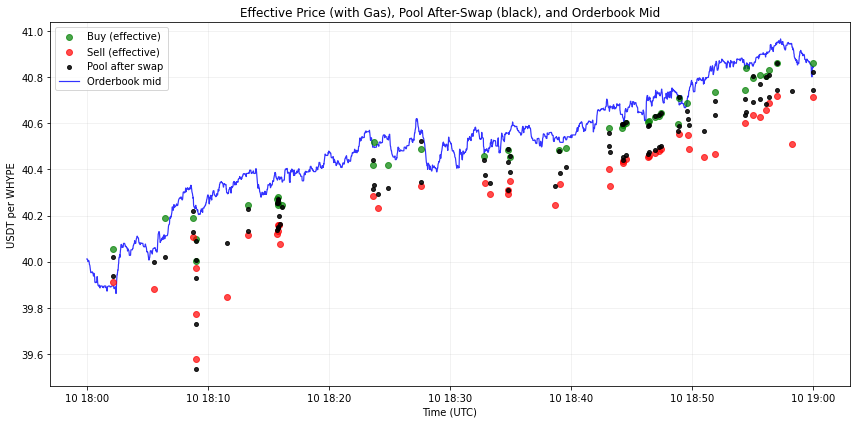

In [10]:
import matplotlib.pyplot as plt

# Filter for non-null effective prices, pool-after price, and side
plot_df = df_events.dropna(subset=['effective_price', 'price_usdt_per_whype', 'hype_side'])

# Prepare buys and sells
buys = plot_df[plot_df['hype_side'] == 'buy']
sells = plot_df[plot_df['hype_side'] == 'sell']

# If orderbook mid is available, overlay it
if 'df' in globals() and {'time', 'mid_price'}.issubset(df.columns):
    # Resample mid price to 1-second intervals for smoother plotting
    mid_resampled = (
        df[['time', 'mid_price']]
          .dropna()
          .set_index('time')
          .resample('1S')
          .median()
          .dropna()
    )

    fig, ax = plt.subplots(figsize=(12, 6))
    # Effective prices
    ax.scatter(buys['datetime'], buys['effective_price'], color='green', label='Buy (effective)', alpha=0.7, zorder=3)
    ax.scatter(sells['datetime'], sells['effective_price'], color='red', label='Sell (effective)', alpha=0.7, zorder=3)
    # Pool price after execution (black)
    ax.scatter(plot_df['datetime'], plot_df['price_usdt_per_whype'], color='black', label='Pool after swap', s=16, alpha=0.85, zorder=3)
    # Orderbook mid (blue line)
    ax.plot(mid_resampled.index, mid_resampled['mid_price'], color='blue', label='Orderbook mid', linewidth=1.2, alpha=0.8)

    ax.set_title('Effective Price (with Gas), Pool After-Swap (black), and Orderbook Mid')
    ax.set_xlabel('Time (UTC)')
    ax.set_ylabel('USDT per WHYPE')
    ax.legend()
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()
else:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.scatter(buys['datetime'], buys['effective_price'], color='green', label='Buy (effective)', alpha=0.7, zorder=3)
    ax.scatter(sells['datetime'], sells['effective_price'], color='red', label='Sell (effective)', alpha=0.7, zorder=3)
    # Pool price after execution (black)
    ax.scatter(plot_df['datetime'], plot_df['price_usdt_per_whype'], color='black', label='Pool after swap', s=16, alpha=0.85, zorder=3)

    ax.set_title('Effective Price (with Gas) and Pool After-Swap (black)')
    ax.set_xlabel('Time (UTC)')
    ax.set_ylabel('USDT per WHYPE')
    ax.legend()
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

In [11]:
plot_df

,event,tx_hash,block,timestamp,log_index,token_0_balance_before,token_0_balance_after,token_1_balance_before,token_1_balance_after,sender,...,liquidity,tick,gasPaidWei,gas_paid_hype,price_usdt_per_whype,price_whype_per_usdt,datetime,price_usdt_per_whype_qty,effective_price,hype_side
0,Swap,1271a12f62208f1ab6dfd7ca66fd0083a85653c48507a6...,5421764,1749578528,11,40652.888209,40630.200102,583403.330221,584082.080221,0x1dA6b648B829ACBE15eb747c3468e1C55d7B92C0,...,253293152038817,-239450,105770000000000,0.000106,39.936477,0.025040,2025-06-10 18:02:08+00:00,39.978986,39.911523,sell
1,Swap,809add547ac8eccc54cc16fbffc9bced7d3c2047181162...,5421765,1749578529,8,40571.888122,40547.908304,585702.710206,586581.710206,0xCCC5C030689364f80eA993565B8C4109E978809A,...,253293152038817,-239429,61518090956084,0.000062,40.019485,0.024988,2025-06-10 18:02:09+00:00,39.997964,40.057129,buy
2,Swap,43efb397e4c7991710ccef7057ba940f31c803ce7c67cd...,5421971,1749578732,3,40423.704773,40423.704773,591138.953391,591138.953391,0x4E2960a8cd19B467b82d26D83fAcb0fAE26b094D,...,253293152038817,-239434,27379200000000,0.000027,39.999512,0.025000,2025-06-10 18:05:32+00:00,39.989400,39.879912,sell
3,Swap,3e456c90d7db59635c35169cfca795eb56b1a1392cbb34...,5422027,1749578787,4,40423.704773,40423.704773,591138.953391,591138.953391,0x4E2960a8cd19B467b82d26D83fAcb0fAE26b094D,...,253293152038817,-239429,39616000000000,0.000040,40.019475,0.024988,2025-06-10 18:06:27+00:00,40.029512,40.188252,buy
4,Swap,1d45da48d9c2745a96c14c3a9b4accebd1e90ea4262913...,5422168,1749578926,10,40355.739593,40355.739593,593636.382099,593636.382099,0x1dA6b648B829ACBE15eb747c3468e1C55d7B92C0,...,253293152038817,-239379,119490960000000,0.000119,40.220508,0.024863,2025-06-10 18:08:46+00:00,40.139937,40.187810,buy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,Swap,e4d3dba72cf96b027ae986d820737936c2e13cbcfc06e7...,5425107,1749581817,8,37371.830860,37373.380495,705090.344779,693076.184244,0x1dA6b648B829ACBE15eb747c3468e1C55d7B92C0,...,253293152038817,-239220,93120600000000,0.000093,40.863694,0.024472,2025-06-10 18:56:57+00:00,40.808424,40.860116,buy
83,Swap,794fce1a5f2677e5d90b650439b6fca3f7b134bcc52d8d...,5425108,1749581818,19,37628.224526,37628.224526,695437.609302,695437.609302,0xCCC5C030689364f80eA993565B8C4109E978809A,...,253293152038817,-239249,91848697747704,0.000092,40.745175,0.024543,2025-06-10 18:56:58+00:00,40.783988,40.718971,sell
84,Swap,0b6b5f3dda40ce71e023e3ca270bc5544e1ac816b77e1b...,5425184,1749581892,5,37711.700731,37737.133950,692309.403095,691352.920120,0x4E2960a8cd19B467b82d26D83fAcb0fAE26b094D,...,253293152038817,-239251,15448420000000,0.000015,40.739018,0.024546,2025-06-10 18:58:12+00:00,40.721667,40.511972,sell
85,Swap,fcaed429c8a972bf12bfa5f382b8d7cfefca57812caf30...,5425289,1749581996,16,37783.973560,37783.402585,691241.032359,691241.032359,0xCCC5C030689364f80eA993565B8C4109E978809A,...,253293152038817,-239230,61989248228115,0.000062,40.822882,0.024496,2025-06-10 18:59:56+00:00,40.801353,40.863369,buy


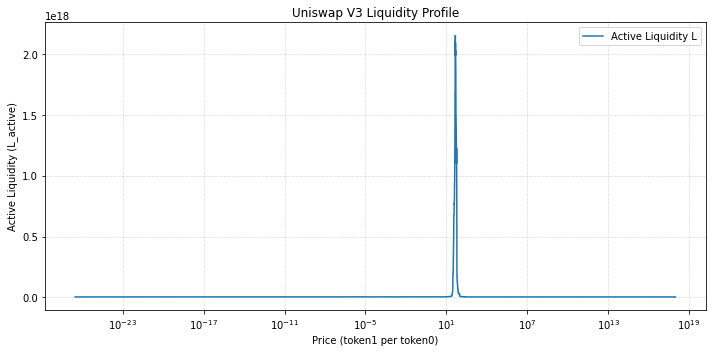

In [14]:
# pip install pandas matplotlib
import pandas as pd
import matplotlib.pyplot as plt

# === Load the CSV ===
df = pd.read_csv(r"C:\Users\rosha\hyper\hyperamm\liquidity_stair_intervals.csv")  # replace with your actual filename

# === Plot liquidity as a step chart ===
plt.figure(figsize=(10, 5))
plt.step(df["price_L"], df["L_active"], where='post', label="Active Liquidity L")

# Optional: log scale if price spans large range
plt.xscale("log")

plt.xlabel("Price (token1 per token0)")
plt.ylabel("Active Liquidity (L_active)")
plt.title("Uniswap V3 Liquidity Profile")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


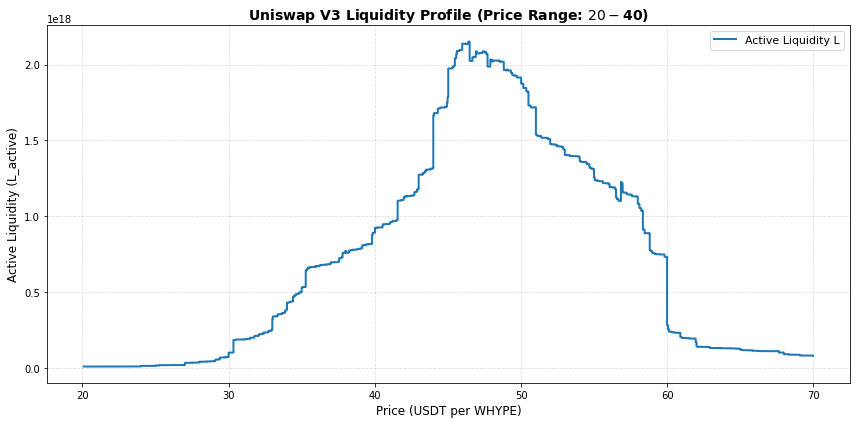


LIQUIDITY SUMMARY (Price Range $20 - $40)
Total intervals: 699
Average liquidity: 819,111,284,457,858,816.00
Max liquidity: 2,151,747,879,124,729,856.00 at price $46.395886
Min liquidity: 8,226,395,523,563,808.00 at price $20.090612

Top 5 liquidity intervals:
       price_L    price_U             L_active
433  46.395886  46.488766  2151747879124729775
432  46.349515  46.395886  2139245927770312737
426  46.026218  46.072265  2138413502932346901
425  45.980217  46.026218  2138311438477125959
427  46.072265  46.164497  2137959892827883010


In [16]:
# Plot liquidity profile between price 20 and 40 USDT per WHYPE
import pandas as pd
import matplotlib.pyplot as plt

# Load the liquidity stair intervals CSV
df_liq = pd.read_csv(r"C:\Users\rosha\hyper\hyperamm\liquidity_stair_intervals.csv")

# Filter for price range 20 to 40
df_filtered = df_liq[(df_liq["price_L"] >= 20) & (df_liq["price_L"] <= 70)]

# Plot liquidity as a step chart
plt.figure(figsize=(12, 6))
plt.step(df_filtered["price_L"], df_filtered["L_active"], where='post', label="Active Liquidity L", linewidth=2)

plt.xlabel("Price (USDT per WHYPE)", fontsize=12)
plt.ylabel("Active Liquidity (L_active)", fontsize=12)
plt.title("Uniswap V3 Liquidity Profile (Price Range: $20 - $40)", fontsize=14, fontweight='bold')
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# Print summary statistics for this range
print(f"\n{'='*60}")
print(f"LIQUIDITY SUMMARY (Price Range $20 - $40)")
print(f"{'='*60}")
print(f"Total intervals: {len(df_filtered)}")
print(f"Average liquidity: {df_filtered['L_active'].mean():,.2f}")
print(f"Max liquidity: {df_filtered['L_active'].max():,.2f} at price ${df_filtered.loc[df_filtered['L_active'].idxmax(), 'price_L']:.6f}")
print(f"Min liquidity: {df_filtered['L_active'].min():,.2f} at price ${df_filtered.loc[df_filtered['L_active'].idxmin(), 'price_L']:.6f}")
print(f"\nTop 5 liquidity intervals:")
print(df_filtered.nlargest(5, 'L_active')[['price_L', 'price_U', 'L_active']])